# The vending machine problem

Suppose we are a vending machine company with vending machines scattered accross the country. We have a certain number of machine techincians that need to visit each machine. How do we minimise the time taken to visit all the machines?

To model this we'll use a 1 by 1 graph and randomly place the machines locations and technician starting points.

In [1]:
# suppress warning messages

import warnings
warnings.filterwarnings("ignore")

# import the random module

from random import random

no_of_machines = 10
no_of_techs = 2

# place the machines and technicians

machine_list = []
tech_list = []

for i in range(no_of_machines):
    machine_list.append((random(), random()))

for i in range(no_of_techs):
    tech_list.append((random(), random()))

Let's take a look at what we've created.

<IPython.core.display.Javascript object>


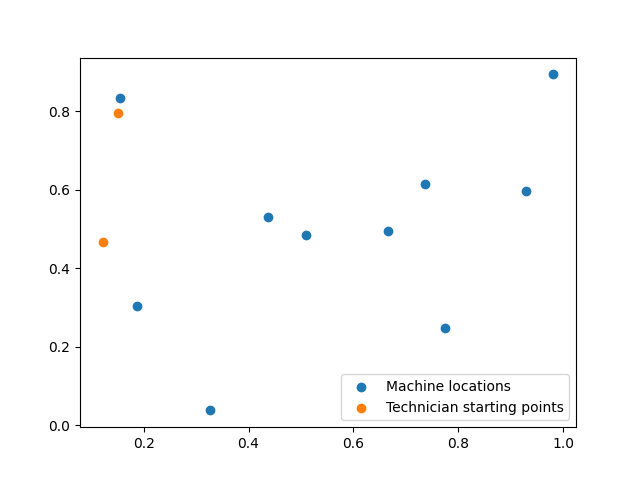

In [2]:
# import the plotting library

import matplotlib.pyplot as plt
%matplotlib notebook

# create the figure

plt.figure()

# zip and plot the machine list

x, y = zip(*machine_list)
plt.scatter(x, y)

# zip and plot the tech list

x, y = zip(*tech_list)
plt.scatter(x, y)

plt.axes().legend(['Machine locations', 'Technician starting points'])

Let's assume that the time taken to travel between any two points is directly correlated with the euclidean distance. Thus we need a distance function.

In [3]:
from math import sqrt

# define the distance function

def d(p1, p2):
    return sqrt(pow(p1[0] - p2[0], 2) + pow(p1[1] - p2[1], 2))

# test the function

print(d((0, 0), (1, 1)))

1.4142135623730951


The function returns the square root of 2 as we had hoped.

We will need to calculate paths between points whilst stipulating that each path must begin at a tech point and end at the same point. A path will be noted by a list of machine points with each technician having their own path list. Note that an empty path list would mean that the technician did not visit any points. Let's visualise this idea.

<IPython.core.display.Javascript object>


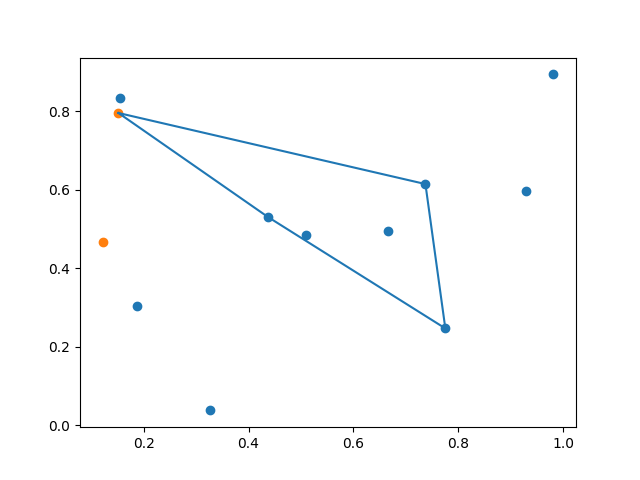

In [4]:
# plot the graph as seen above

path_list = [0, 4, 5]
tech = 0

# create the figure

plt.figure()

# zip and plot the machine list

x, y = zip(*machine_list)
plt.scatter(x, y)

# zip and plot the tech list

x, y = zip(*tech_list)
plt.scatter(x, y)

# draw the path

x, y = zip(*[tech_list[0], machine_list[0], machine_list[4], machine_list[5], tech_list[0]])

plt.axes().plot(x, y);

But how much distance is covered here? Let's write another function that calculates the distance of a path given the tech number and the path list.

In [7]:
def d_path(tech, path_list, tech_list, machine_list):
    
    if len(path_list) == 0:
        return 0
    
    distance = d(tech_list[tech], machine_list[path_list[0]]) + d(tech_list[tech], machine_list[path_list[-1]])
    
    for i in range(len(path_list)-1):
        distance += d(machine_list[path_list[i]], machine_list[path_list[i+1]])
                      
    return distance
                      
# lets test this function on the path that we drew above

print(d_path(tech, path_list, tech_list, machine_list))

1.8122910959884586


The distance seems correct by eye.

If we are to use a brute force type method, we would need to try all the points in every permutation with every technician with every size of path for each technician. This is too many calculations. If we look at the path above we can see that we can shorten the path whilst using the same points i.e find a minimum path of the points. Finding a minimaum path is simple, we just always move to the nearest unvisited point of the path. Let's update our path distance function to find the minimum distance.

In [8]:
import itertools

def d_min_path(tech, path_list, tech_list, machine_list):
    if len(path_list) == 0:
        return (0, [])
    min_distance = len(path_list) + 2
    for perm in list(itertools.permutations(path_list)):
        distance = d_path(tech, perm, tech_list, machine_list)
        if distance < min_distance:
            min_distance = distance
            path = perm
    return min_distance, list(path)

# let's test this on the points that we used before to find a minimal path
                 
print(d_min_path(tech, path_list, tech_list, machine_list))

(1.8122910959884586, [0, 4, 5])


This has indeed lowered the total distance, but to be sure everything is working properly we'll make a list of points so that there is a point in each corner. The path list will go from one corner to the opposite corner (the non-ideal path) to test whether our function finds the quickest path which should be around the border.

In [9]:
print(d_min_path(0, [0, 1, 2], [(0, 0)], [(0, 1), (1, 0), (1, 1)]))

(4.0, [0, 2, 1])


Our code seems to be working perfectly. Let's write a function that can brute force calculate the ideal solution to the problem with only 2 technicians.

In [10]:
from time import time

def solve2(tech_list, machine_list):
    start = time()
    
    min_distance = 3*len(machine_list)
    
    path_list = range(len(machine_list))
    
    for i in range(len(machine_list)+1):
        for perm in list(itertools.combinations(path_list, i)):
            other_perm = [item for item in path_list if item not in perm]
            distance_path1 = d_min_path(0, perm, tech_list, machine_list)
            distance_path2 = d_min_path(1, other_perm, tech_list, machine_list)
            distance = distance_path1[0] + distance_path2[0]
            if distance < min_distance:
                min_distance = distance
                min_paths = [distance_path1[1], distance_path2[1]]
    
    print('Solution found in ' + str((time() - start)/60) + ' minutes.')
    
    return min_distance, min_paths
    
solution = solve2(tech_list, machine_list)

print(solution)

Solution found in 2.389825467268626 minutes.
(2.80281985266034, [[9], [0, 7, 1, 5, 6, 8, 4, 2, 3]])


The solution took quite a long time for such a simple problem. Let's visualise it.

<IPython.core.display.Javascript object>


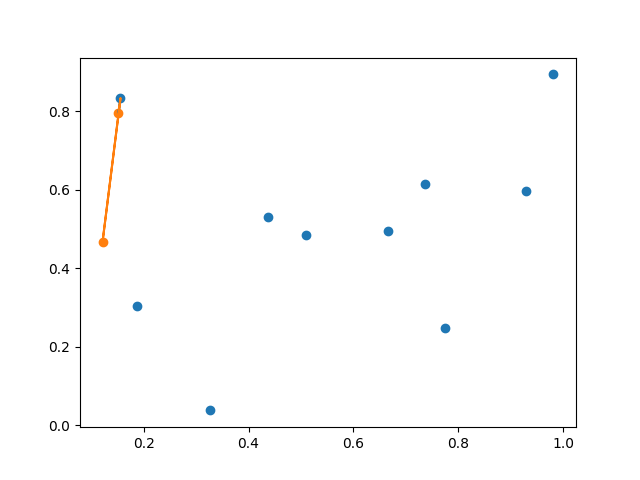

In [14]:
# create the figure

plt.figure()

# zip and plot the machine list

x, y = zip(*machine_list)
plt.scatter(x, y)

# zip and plot the tech list

x, y = zip(*tech_list)
plt.scatter(x, y)

# draw the paths

for i in range(len(solution[1])):
    points_list = []
    points_list.append(tech_list[i])
    for j in solution[1][0]:
        points_list.append(machine_list[j])
    points_list.append(tech_list[i])
        
    x, y = zip(*points_list)
    plt.axes().plot(x, y);

# Clustering method

Given the copius amounts of time that the brute force method takes, we need to find a more streamlined solution. We can tweak the idea of points clustering from machine learning to have a kind of path clustering.

If we give each technician a random path to begin with we can then look at each point individually and test if changing which path it is a part of improves the overall distance. If it does, then we simply swap it over to another path and move on to the next point.

Let's start by giving each technician their own random path.

In [86]:
from random import randint

path = list(itertools.permutations(range(10), randint(0, 9)))

path = path[randint(0, len(path)-1)]
            
path_list = [list(path), [i for i in range(10) if i not in path]]
            
print(path_list)

[[9, 8, 0, 1, 3], [2, 4, 5, 6, 7]]


Now that we have our two paths, let's try the clustering technique. A key reason that this method will be quicker is the fact that we don't have to keep recalculating the best paths since we can add a point to a path by finding the nearest centre point between two link points and slot it in.

In [87]:
def midpoint(x1, x2):
    return ((x1[0] + x2[0])/2,(x1[1] + x2[1])/2)

def cluster(tech_list, machine_list, path_list, iterations):
    
    tech_length = len(tech_list)
    number_of_points = len(machine_list) + tech_length

    # find the ideal paths from the random paths given and calculate the total distance
    distance_list = [0]*tech_length
    for i in range(tech_length):
        distance_path = d_min_path(0, path_list[0], tech_list, machine_list)
        path_list[i] = distance_path[1]
        distance_list[i] = distance_path[0]

    for counter in range(iterations):
        for point in range(number_of_points):
            # find the distance saved by removing the point from it's current path
            for tech in range(tech_length):
                if point in path_list[tech]:
                    new_path = path_list[tech].copy()
                    new_path.remove(point)
                    distance_saved = distance_list[tech] - d_path(tech, new_path, tech_list, machine_list)
                    point_path = [new_path, tech]
                    break
            # calculate the distances added by adding the point to all other paths
            min_distance_added = 100
            for tech in range(tech_length):
                if point not in path_list[tech]:
                    # if the path is empty just chuck in the point
                    if len(path_list[tech]) == 0:
                        distance_added = d_path(tech, [point], tech_list, machine_list) - distance_list[tech]
                    # if it's not empty find the best place to place the point
                    else:
                        mid_point = midpoint(tech_list[tech], machine_list[path_list[tech][0]])
                        min_mid_point = d(mid_point, machine_list[point])
                        placement = 0
                        for i in range(len(path_list[tech])-1):
                            mid_point = midpoint(machine_list[path_list[tech][i]], machine_list[path_list[tech][i+1]])
                            distance_from_mid_point = d(mid_point, machine_list[point])
                            if distance_from_mid_point < min_mid_point:
                                min_mind_point = distance_from_mid_point
                                placement = i+1
                        mid_point = midpoint(tech_list[tech], machine_list[path_list[tech][-1]])
                        distance_from_mid_point = d(mid_point, machine_list[point])
                        if distance_from_mid_point < min_mid_point:
                            placement = len(path_list[tech])
                        # place the point
                        new_path = path_list[tech].copy()
                        new_path.insert(placement, point)
                        # find the added distance
                        distance_added = d_path(tech, new_path, tech_list, machine_list) - distance_list[tech]
                    if distance_added < min_distance_added:
                        min_distance_added = distance_added
                        best_path = [new_path, tech]
            # if it's worth moving the point then let's move it
            if min_distance_added < distance_saved:
                distance_list[best_path[1]] += min_distance_added
                distance_list[point_path[1]] -= distance_saved
                path_list[point_path[1]] = point_path[0]
                path_list[best_path[1]] = best_path[0]
                                             
solution = cluster(tech_list, machine_list, path_list, 1)

AttributeError: 'tuple' object has no attribute 'copy'

In [88]:
print(path_list)

[(3, 8, 0, 1, 9), (3, 8, 0, 1, 9)]
